In [1]:
# James Philbrick, March 2022

# preprocess image -> generate point cloud -> mesh -> export stl
# for now, this only works with square images (see the get_points_indes() function)

# Lithophane Generation Settings: --
# Maximum Thickness: 3mm
# Minimum Thinness: .6mm or .2 plus your nozzle size
# Negative: If you have the option print with a negative setting

# Slicer Settings: --
# Infill: 100%
# Perimeters: 10
# Perimeter Speeds: 35mm/s - 45mm/s
# Print Along the Y direction

In [2]:
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pyvista as pv
import time
from PIL import Image
from stl import mesh

In [3]:
global IMG_FILENAME; IMG_FILENAME = 'tom200200.jpg'
global CONST_D; CONST_D = 0.6 # mm?
global CONST_H; CONST_H = 3 # mm?
global IMG_WIDTH; IMG_WIDTH = (Image.open(IMG_FILENAME).size)[0]
global IMG_HEIGHT; IMG_HEIGHT = (Image.open(IMG_FILENAME).size)[1]

In [4]:
def preprocess(img):
    return np.dot(img[...,:3], [0.2989, 0.5870, 0.1140])

In [5]:
def gen_point_cloud(img):
#     create np array of the form point_cloud = [[x, y, z, r, g, b], ... for each point]
#     append this array to the pointCloud variable using np.append

    pointCloud = np.zeros(shape=(2*IMG_WIDTH*IMG_HEIGHT, 3))
    pointCloudImg = np.zeros(shape=(IMG_WIDTH, IMG_HEIGHT))
    
#     create surface
    n = -1
    for x, xpos in enumerate(range(IMG_WIDTH)):
        for y, ypos in enumerate(range(IMG_HEIGHT)):
            n += 1
            p = img[x][y]
            z = CONST_H*(1-(p/255))+CONST_D
            pointCloudImg[x][y] = z
            pointCloud[n] = np.array([x, y, z])
     
    # create back surface
    n = -1
    for x, xpos in enumerate(range(IMG_WIDTH)):
        for y, ypos in enumerate(range(IMG_HEIGHT)):
            n += 1
            pointCloud[n + (IMG_WIDTH*IMG_HEIGHT)] = np.array([x, y, 0])
    
    return pointCloud, pointCloudImg

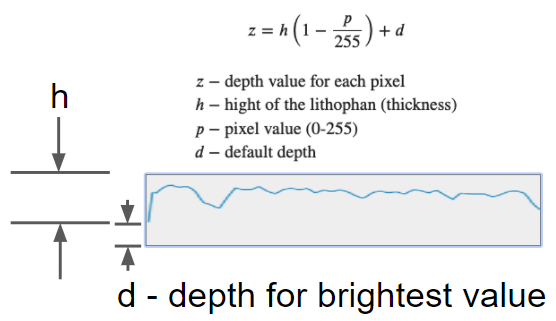

In [6]:
def get_points_index(x, y):
    return x*IMG_HEIGHT + y

In [7]:
def gen_mesh(pointCloud):
    # top surface -------------------------------------------------------------------------------------------------
    surfVertices = pointCloud[:(IMG_WIDTH*IMG_HEIGHT)]
    surfTris = np.array([[0, 0, 0]]) # create np array of tri arrays
    for x, i in enumerate(range(IMG_WIDTH-1)):
        for y, j in enumerate(range(IMG_HEIGHT-1)):
            tri1 = np.array([get_points_index(i, j), get_points_index(i+1, j), get_points_index(i+1, j+1)])
            tri2 = np.array([get_points_index(i, j), get_points_index(i, j+1), get_points_index(i+1, j+1)])
            surfTris = np.concatenate((surfTris, [tri1]), axis=0)
            surfTris = np.concatenate((surfTris, [tri2]), axis=0)
    surfTris = np.delete(surfTris, 0, 0)
    
    # back surface ------------------------------------------------------------------------------------------------
    backVertices = pointCloud[(IMG_WIDTH*IMG_HEIGHT):]
    offset = IMG_WIDTH*IMG_HEIGHT
    backTris = np.array([[0, 0, 0]]) # create np array of tri arrays
    for x, i in enumerate(range(IMG_WIDTH-1)):
        for y, j in enumerate(range(IMG_HEIGHT-1)):
            tri1 = np.array([get_points_index(i, j), get_points_index(i+1, j), get_points_index(i+1, j+1)]) + offset
            tri2 = np.array([get_points_index(i, j), get_points_index(i, j+1), get_points_index(i+1, j+1)]) + offset
            backTris = np.concatenate((backTris, [tri1]), axis=0)
            backTris = np.concatenate((backTris, [tri2]), axis=0)
    backTris = np.delete(backTris, 0, 0)
    
    # sides -------------------------------------------------------------------------------------------------------
    sideTris = np.array([[0, 0, 0]])
    
    # left and right
    for y, j in enumerate(range(IMG_HEIGHT-1)):
        lTri1 = np.array([get_points_index(0, j), get_points_index(0, j)+offset, get_points_index(0, j+1)+offset])
        lTri2 = np.array([get_points_index(0, j), get_points_index(0, j+1), get_points_index(0, j+1)+offset])
        sideTris = np.concatenate((sideTris, [lTri1]), axis=0)
        sideTris = np.concatenate((sideTris, [lTri2]), axis=0)
        
        x = IMG_HEIGHT-1
        rTri1 = np.array([get_points_index(x, j), get_points_index(x, j)+offset, get_points_index(x, j+1)+offset])
        rTri2 = np.array([get_points_index(x, j), get_points_index(x, j+1), get_points_index(x, j+1)+offset])
        sideTris = np.concatenate((sideTris, [rTri1]), axis=0)
        sideTris = np.concatenate((sideTris, [rTri2]), axis=0)
    
    # top and bottom
    for x, i in enumerate(range(IMG_WIDTH-1)):
        uTri1 = np.array([get_points_index(i, 0), get_points_index(i, 0)+offset, get_points_index(i+1, 0)+offset])
        uTri2 = np.array([get_points_index(i, 0), get_points_index(i+1, 0), get_points_index(i+1, 0)+offset])
        sideTris = np.concatenate((sideTris, [uTri1]), axis=0)
        sideTris = np.concatenate((sideTris, [uTri2]), axis=0)
        
        y = IMG_WIDTH-1
        dTri1 = np.array([get_points_index(i, y), get_points_index(i, y)+offset, get_points_index(i+1, y)+offset])
        dTri2 = np.array([get_points_index(i, y), get_points_index(i+1, y), get_points_index(i+1, y)+offset])
        sideTris = np.concatenate((sideTris, [dTri1]), axis=0)
        sideTris = np.concatenate((sideTris, [dTri2]), axis=0)
        
    sideTris = np.delete(sideTris, 0, 0)
    
    # combine the surface and back data ---------------------------------------------------------------------------
    combinedTris = np.concatenate((surfTris, backTris), axis=0)
    combinedTris = np.concatenate((combinedTris, sideTris), axis=0)
    # print(combinedTris)
    # print('\n', combinedTris.size)
    # construct the mesh from the data
    cube = mesh.Mesh(np.zeros(combinedTris.shape[0], dtype=mesh.Mesh.dtype))
    for i, f in enumerate(combinedTris):
        for j in range(3):
            cube.vectors[i][j] = pointCloud[f[j],:]

    # Write the mesh to file
    cube.save('teststl.stl')

In [8]:
def main():
    #     open image
    img = mpimg.imread(IMG_FILENAME)
    plt.imshow(img)
    plt.show()
    
#     preprocess image: color -> bw using 0.2989r 0.5870g 0.1140b formula
    img = preprocess(img)
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.colorbar()
    plt.show()
    
#     generate point cloud
    # img = img/np.max(img)
    pointCloud, pointCloudImg = gen_point_cloud(img)
    plt.imshow(pointCloudImg)
    plt.colorbar()
    plt.show()
    
#     mesh the point cloud and save as stl
    gen_mesh(pointCloud)

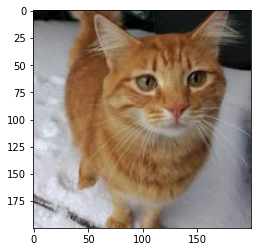

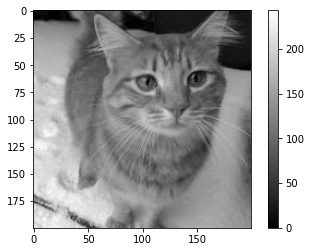

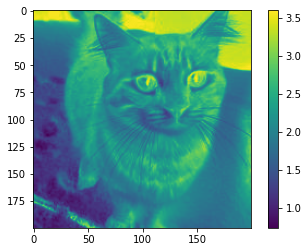

Program executed in --- 15.852341413497925 seconds ---


In [9]:
if __name__ == "__main__":
    startTime = time.time()
    main()
    print("Program executed in --- %s seconds ---" % (time.time() - startTime))